# **K-Medoids vs Fast K-Medoids**

## **Requirements**

In [56]:
import pandas as pd
import polars as pl
import numpy as np
import sys
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, BisectingKMeans, MiniBatchKMeans, DBSCAN
from sklearn.manifold import MDS
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')
import time
import pickle
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_classification, make_blobs
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

In [57]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\BigEDA_Package_Private')
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix

In [58]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyDistances_Package_Private')
from PyDistances.quantitative import Euclidean_dist_matrix
from PyDistances.mixed import GG_dist_matrix

In [59]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\FastKmedoids_Package_Private')
from FastKmedoids.models import FastGG, FastKmedoidsGG, KFoldFastKmedoidsGG 
from FastKmedoids.plots import clustering_MDS_plot
from FastKmedoids.metrics import adjusted_accuracy
from FastKmedoids.data import outlier_contamination

## **Data**

- Same simulation schema as in the first simulation but with smaller data sizes.

In [60]:
data_sizes = [5000, 10000, 15000, 20000, 30000, 40000, 50000]
X_dict, Y = {}, {}

In [61]:
for size in data_sizes:

    X, Y[size] = make_blobs(n_samples=size, centers=4, cluster_std=[2,2,2,3], n_features=8, random_state=123)
    X = pd.DataFrame(X)      
    X.columns = [f"X{i}" for i in range(1, X.shape[1]+1)]

    # Se convierten dos variables cuantitativas a binarias, y otras dos a multiclase, discretizandolas.
    X['X5'] = pd.cut(X['X5'], bins=[X['X5'].min()-1, X['X5'].mean(), X['X5'].max()+1], labels=False)
    X['X6'] = pd.cut(X['X6'], bins=[X['X6'].min()-1, X['X6'].mean(), X['X6'].max()+1], labels=False)
    X['X7'] = pd.cut(X['X7'], bins=[X['X7'].min()-1, X['X7'].quantile(0.25), X['X7'].quantile(0.50), X['X7'].quantile(0.75), X['X7'].max()+1], labels=False)
    X['X8'] = pd.cut(X['X8'], bins=[X['X8'].min()-1, X['X8'].quantile(0.25), X['X8'].quantile(0.50), X['X8'].quantile(0.75), X['X8'].max()+1], labels=False)   

    X = outlier_contamination(X, col='X1', below=False, above=True, prop_above=0.05, dil=2, random_state=123)
    X = outlier_contamination(X, col='X2', above=False, below=True, prop_below=0.05, dil=2, random_state=123)
    X_dict[size] = X.to_numpy().copy()

## **Analysis**

In [62]:
n_splits = {}
for size in data_sizes:
    if size <= 35000:
        n_splits[size] = int(np.ceil((0.05/100)*size)) # (split_ratio/100) * n
    else:
        n_splits[size] = int(np.ceil((0.014/100)*size))

In [85]:
frac_sample_size = {}
for size in data_sizes:
    if size <= 15000:
        frac_sample_size[size] = 0.06
    elif size > 15000 and size < 35000:
        frac_sample_size[size] = 0.05
    elif size >= 35000 and size < 50000:
        frac_sample_size[size] = 0.04
    elif size == 50000:
        frac_sample_size[size] = 0.03

In [86]:
with open('results/cluster_labels_kmedoids_vs_fast_kmedoids.pkl', 'rb') as file:
    cluster_labels = pickle.load(file)
with open('results/times_kmedoids_vs_fast_kmedoids.pkl', 'rb') as file:
    times = pickle.load(file)

In [87]:
del cluster_labels['Fast K-Medoids-GG_RobustMaha']
del times['Fast K-Medoids-GG_RobustMaha']

cluster_labels['K-Fold Fast K-Medoids-GG_RobustMaha'] = {}
times['K-Fold Fast K-Medoids-GG_RobustMaha'] = {}

In [ ]:
for size in data_sizes:
    print(size)
 
    fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                                    frac_sample_size=frac_sample_size[size], p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                                    robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20, VG_sample_size=1000, VG_n_samples=5,
                                    n_splits=n_splits[size], shuffle=True, kfold_random_state=111,)
    start_time = time.time()
    fast_kmedoids.fit(X=X_dict[size]) 
    end_time = time.time()
    times['K-Fold Fast K-Medoids-GG_RobustMaha'][size] = end_time - start_time
    cluster_labels['K-Fold Fast K-Medoids-GG_RobustMaha'][size] = fast_kmedoids.labels

In [89]:
model_names = cluster_labels.keys()
best_accuracy, best_cluster_labels = {model: {} for model in model_names}, {model: {} for model in model_names}

for model_name in model_names:
    for size in data_sizes:
        try:
            best_accuracy[model_name][size], best_cluster_labels[model_name][size] = adjusted_accuracy(y_pred=cluster_labels[model_name][size], y_true=Y[size])
        except:
            pass

In [90]:
# To avoid problems in the plots: process 'Memory-Error' value as None
for model_name in model_names:
    for size in data_sizes:
        if times[model_name][size] == 'Memory-Error':
            times[model_name][size] = None

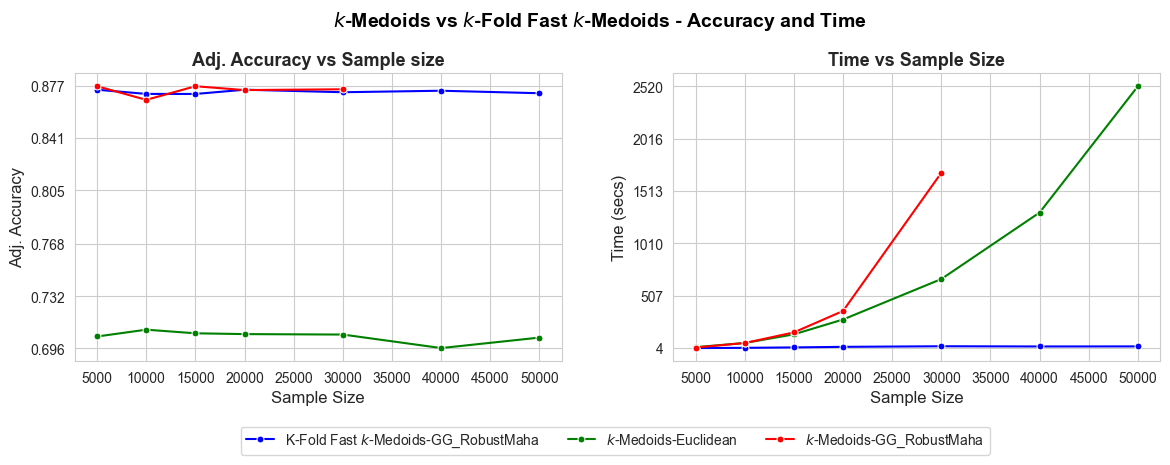

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes = axes.flatten()  

#######################################################################
# Accuracy plot 

sns.lineplot(x=best_accuracy['K-Fold Fast K-Medoids-GG_RobustMaha'].keys(), 
             y=best_accuracy['K-Fold Fast K-Medoids-GG_RobustMaha'].values(), 
             color='blue', marker='o',  markersize=5, 
             label='K-Fold Fast $k$-Medoids-GG_RobustMaha', ax=axes[0])

sns.lineplot(x=best_accuracy['K-Medoids-Euclidean'].keys(), 
             y=best_accuracy['K-Medoids-Euclidean'].values(), 
             color='green', marker='o',  markersize=5, 
             label='$k$-Medoids-Euclidean', ax=axes[0])

sns.lineplot(x=best_accuracy['K-Medoids-GG_RobustMaha'].keys(), 
             y=best_accuracy['K-Medoids-GG_RobustMaha'].values(), 
             color='red', marker='o',  markersize=5, 
             label='$k$-Medoids-GG_RobustMaha', ax=axes[0])

#######################################################################
# Time plot 

sns.lineplot(x=times['K-Fold Fast K-Medoids-GG_RobustMaha'].keys(), 
             y=times['K-Fold Fast K-Medoids-GG_RobustMaha'].values(), 
             color='blue', marker='o', markersize=5, 
             label='K-Fold Fast $k$-Medoids-GG_RobustMaha', ax=axes[1])

sns.lineplot(x=times['K-Medoids-Euclidean'].keys(), 
             y=times['K-Medoids-Euclidean'].values(), 
             color='green', marker='o', markersize=5, 
             label='$k$-Medoids-Euclidean', ax=axes[1])

sns.lineplot(x=times['K-Medoids-GG_RobustMaha'].keys(), 
             y=times['K-Medoids-GG_RobustMaha'].values(), 
             color='red', marker='o', markersize=5, 
             label='$k$-Medoids-GG_RobustMaha', ax=axes[1])

#######################################################################
# Plot details

axes[0].set_title('Adj. Accuracy vs Sample size', size=13, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=12)
min_acc = min([min(best_accuracy[model].values()) for model in model_names])
max_acc = max([max(best_accuracy[model].values()) for model in model_names])
axes[0].set_yticks(np.round(np.linspace(min_acc, max_acc, 6),3))

axes[1].set_title('Time vs Sample Size', size=13, weight='bold')
axes[1].set_ylabel('Time (secs)', size=12)
min_time = min([min([x for x in times[model].values() if x != None]) for model in model_names])
max_time = max([max([x for x in times[model].values() if x != None]) for model in model_names])
axes[1].set_yticks(np.round(np.linspace(min_time, max_time, 6),3))

for i in range(len(axes)):
    axes[i].set_xticks(data_sizes + [25000, 35000, 45000])
    axes[i].set_xlabel('Sample Size', size=12)
    axes[i].legend().set_visible(False)


handles, labels = axes[1].get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(-0.12, -0.35), ncol=len(labels), fontsize=10)
plt.subplots_adjust(top=0.83)
plt.suptitle('$k$-Medoids vs $k$-Fold Fast $k$-Medoids - Accuracy and Time', fontsize=14, y=0.99, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 


#file_name = 'plots/kmedoids_vs_kfold_fast_kmedoids'
#fig.savefig(file_name + '.jpg', format='jpg', dpi=500, bbox_inches="tight", pad_inches=0.2)

plt.show()